In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

In [52]:
page_number = 43026

In [53]:
def get_latencies_and_errors(page_number, model_or_hpa):
        error_with_time = []
        latency_with_time = []
        with open(f'./latency/{page_number}_{model_or_hpa}_latencyAndError.log', 'r') as file:
            start_time = None
            for line in file:
                log = line.strip().split(",")
                timestamp =  float(log[1])

                if start_time == None:
                    start_time = timestamp

                if "error" in line:
                    error_with_time.append([1, timestamp - start_time ])
                else:
                    latency_line = log[0]
                    latency = float( latency_line.split(":")[-1] )
                    latency_with_time.append([latency, timestamp - start_time ])

        error_with_time.sort(key=lambda x: x[1])
        latency_with_time.sort(key=lambda x: x[1])

        return latency_with_time, aggregate_errors_5_seconds(error_with_time)

def get_pods_analysis(page_number, model_or_hpa):
    pods_counts = []
    maxes = []
    mins = []
    averages = []
    times = []
    with open(f'./pods_analysis/{page_number}_{model_or_hpa}_pods_analysis.log', 'r') as file:
        start_time = None
        for line in file:
            log = line.strip().split(",")
            count = int(log[0].split(":")[-1])
            max_ = float(log[1])
            min_ = float(log[2])
            average_ = float(log[3])
            timestamp = float(log[4])   
            if start_time == None:
                start_time = timestamp

            pods_counts.append(count)
            maxes.append(max_)
            mins.append(min_)
            averages.append(average_)
            times.append(timestamp - start_time)

    return pods_counts, maxes, mins, averages, times

def aggregate_errors_5_seconds(errors_with_times):
    aggregated_data = {}

    for value, timestamp in errors_with_times:
        group_key = int(timestamp // 5)

        if group_key in aggregated_data:
            aggregated_data[group_key] += value
        else:
            aggregated_data[group_key] = value

    aggregated_list = [[value, key * 5] for key, value in aggregated_data.items()]

    return aggregated_list
     

In [54]:
model_counts, model_maxes, model_mins , model_averages, model_times = get_pods_analysis(page_number, "model")
hpa_counts, hpa_maxes, hpa_mins , hpa_averages, hpa_times = get_pods_analysis(page_number, "hpa")

model_latencies, model_errors = get_latencies_and_errors(page_number, "model")
hpa_latencies, hpa_errors = get_latencies_and_errors(page_number, "hpa")

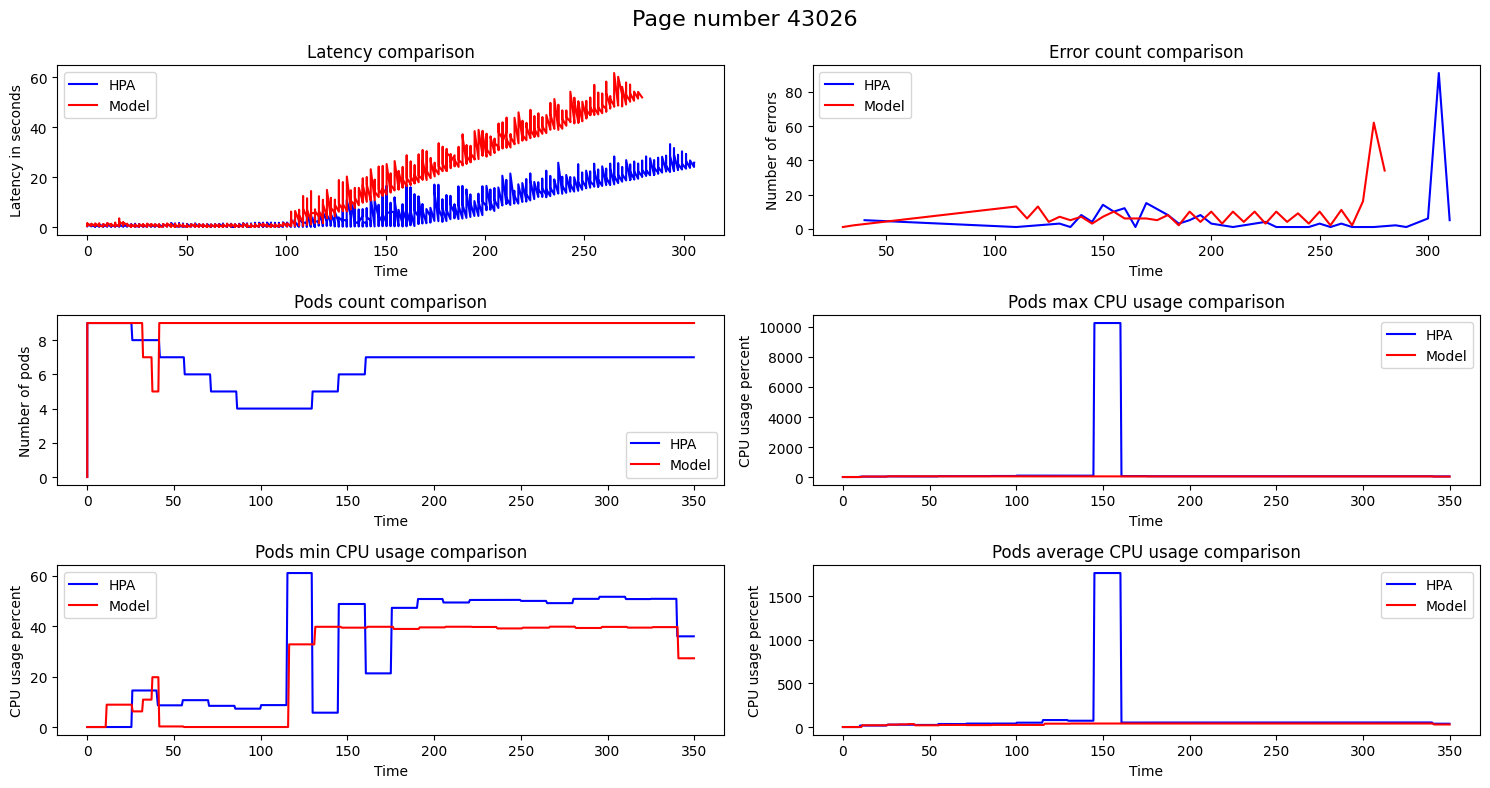

In [55]:
fig, axs = plt.subplots(3, 2, figsize=(15, 8))


axs[0][0].plot([item[1] for item in hpa_latencies] , [item[0] for item in hpa_latencies], color='blue', label='HPA')
axs[0][0].plot([item[1] for item in model_latencies] , [item[0] for item in model_latencies], color='red', label='Model')
axs[0][0].set_title('Latency comparison')
axs[0][0].set_xlabel('Time')
axs[0][0].set_ylabel('Latency in seconds')
axs[0][0].legend()

axs[0][1].plot([item[1] for item in hpa_errors] , [item[0] for item in hpa_errors], color='blue', label='HPA')
axs[0][1].plot([item[1] for item in model_errors] , [item[0] for item in model_errors], color='red', label='Model')
axs[0][1].set_title('Error count comparison')
axs[0][1].set_xlabel('Time')
axs[0][1].set_ylabel('Number of errors')
axs[0][1].legend()

axs[1][0].plot(hpa_times, hpa_counts, color='blue', label='HPA')
axs[1][0].plot(model_times, model_counts, color='red', label='Model')
axs[1][0].set_title('Pods count comparison')
axs[1][0].set_xlabel('Time')
axs[1][0].set_ylabel('Number of pods')
axs[1][0].legend()

axs[1][1].plot(hpa_times, hpa_maxes, color='blue', label='HPA')
axs[1][1].plot(model_times, model_maxes, color='red', label='Model')
axs[1][1].set_title('Pods max CPU usage comparison')
axs[1][1].set_xlabel('Time')
axs[1][1].set_ylabel('CPU usage percent')
axs[1][1].legend()

axs[2][0].plot(hpa_times, hpa_mins, color='blue', label='HPA')
axs[2][0].plot(model_times, model_mins, color='red', label='Model')
axs[2][0].set_title('Pods min CPU usage comparison')
axs[2][0].set_xlabel('Time')
axs[2][0].set_ylabel('CPU usage percent')
axs[2][0].legend()

axs[2][1].plot(hpa_times, hpa_averages, color='blue', label='HPA')
axs[2][1].plot(model_times, model_averages, color='red', label='Model')
axs[2][1].set_title('Pods average CPU usage comparison')
axs[2][1].set_xlabel('Time')
axs[2][1].set_ylabel('CPU usage percent')
axs[2][1].legend()




plt.suptitle(f'Page number {page_number}', fontsize=16)
plt.tight_layout()
plt.savefig(f"./simulation_comparison/{page_number}_comparison.png")
plt.show()